In [2]:
import pandas as pd

def find_sandwich_orders(df):
    data = df.copy()

    # Ensure Token0 is always the smaller value for consistency
    if data['Token0'][0] > data['Token1'][0]:
        data['Token0'], data['Token1'] = df['Token1'], df['Token0']
        data['Delta0'], data['Delta1'] = df['Delta1'], df['Delta0']

    # Convert timestamps
    data['time'] = pd.to_datetime(data['time'], unit='s')
    data = data.sort_values('time')

    # Label buy and sell orders
    data['type'] = data.apply(lambda row: 'buy' if row['Delta0'] > 0 and row['Delta1'] < 0 else 'sell' if row['Delta0'] < 0 and row['Delta1'] > 0 else 'other', axis=1)

    # Function to detect sandwich orders
    def is_sandwich(buy_order, sell_order):
        ratio = abs(buy_order['Delta0']) / abs(sell_order['Delta0'])
        return 0.9 <= ratio <= 1.1 and buy_order['time'] == sell_order['time'] and buy_order['From'] == sell_order['From']

    # Identify sandwich orders
    sandwich_buys = []
    sandwich_sells = []
    
    for (time, from_address), group in data.groupby(['time', 'From']):
        buys = group[group['type'] == 'buy']
        sells = group[group['type'] == 'sell']
        print(buys)
        for _, buy in buys.iterrows():
            for _, sell in sells.iterrows():
                if is_sandwich(buy, sell):
                    sandwich_buys.append(buy)
                    sandwich_sells.append(sell)
    return sandwich_buys, sandwich_sells

import os
buys = []
sells = []
folder_path = '/Users/ekko/Downloads/coin_data'  # 更改为你的文件夹路径
files = os.listdir(folder_path)
def read(file):
    file_path = os.path.join(folder_path, file)
    df = pd.read_excel(file_path)
    return df

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict
from util import fetch_pool_keys, SOL, swap_token_amount_base_in
# 定义处理交易数据的函数
def process_transaction_data(df):
    data = df.copy()

    # Ensure Token0 is always the smaller value for consistency
    if data['Token0'][0] > data['Token1'][0]:
        data['Token0'], data['Token1'] = df['Token1'], df['Token0']
        data['Delta0'], data['Delta1'] = df['Delta1'], df['Delta0']

    # Convert timestamps
    data['time'] = pd.to_datetime(data['time'], unit='s')
    data = data.sort_values('time')

    # Label buy and sell orders
    data['type'] = data.apply(lambda row: 'buy' if row['Delta0'] > 0 and row['Delta1'] < 0 else 'sell' if row['Delta0'] < 0 and row['Delta1'] > 0 else 'Deposit' if row['Delta0'] > 0 and row['Delta1'] > 0 else 'Withdraw', axis=1)

    # Function to detect sandwich orders
    def is_sandwich(group):
        buy_orders = group[group['type'] == 'buy']['Delta0'].sum()
        sell_orders = group[group['type'] == 'sell']['Delta0'].sum()
        if sell_orders == 0:
            return False
        ratio = buy_orders / abs(sell_orders)
        return 0.9 <= ratio <= 1.1 and buy_orders > 1e10

    # Filter out sandwich orders
    filtered_data = data.groupby(['time', 'From']).filter(lambda group: not is_sandwich(group))
    
    # Calculate VWAP prices
    buy_orders = filtered_data[filtered_data['type'] == 'buy'].copy()
    sell_orders = filtered_data[filtered_data['type'] == 'sell'].copy()

    buy_orders['vwap'] = buy_orders['Delta0'] / abs(buy_orders['Delta1'])
    sell_orders['vwap'] = abs(sell_orders['Delta0']) / abs(sell_orders['Delta1'])

    buy_vwap = buy_orders.groupby('time').apply(lambda x: (x['vwap'] * abs(x['Delta0'])).sum() / abs(x['Delta0']).sum()).reset_index()
    buy_vwap.columns = ['time', 'buy_vwap']

    sell_vwap = sell_orders.groupby('time').apply(lambda x: (x['vwap'] * abs(x['Delta0'])).sum() / abs(x['Delta0']).sum()).reset_index()
    sell_vwap.columns = ['time', 'sell_vwap']

    # Merge buy and sell VWAP prices
    order_vwap = pd.merge(buy_vwap, sell_vwap, on='time', how='outer')
    order_vwap['order_vwap'] = (order_vwap['buy_vwap'].fillna(0) + order_vwap['sell_vwap'].fillna(0)) / 2

    # Calculate pool price
    filtered_data['pool_price'] = filtered_data['Token0'] / filtered_data['Token1']

    # Calculate total inflow and outflow of Token0
    inflow = buy_orders.groupby('time')['Delta0'].sum().reset_index()
    inflow.columns = ['time', 'total_inflow']

    outflow = sell_orders.groupby('time')['Delta0'].sum().reset_index()
    outflow.columns = ['time', 'total_outflow']

    # Get unique time points for pool prices
    pool_data = filtered_data.drop_duplicates(subset=['time']).sort_values(by='time')

    # Merge VWAP, pool price, inflow, and outflow data
    merged_data = pd.merge(order_vwap[['time', 'order_vwap']], pool_data[['time', 'pool_price']], on='time', how='outer')
    merged_data = pd.merge(merged_data, inflow, on='time', how='outer')
    merged_data = pd.merge(merged_data, outflow, on='time', how='outer')

    # Ensure unique time points
    merged_data = merged_data.drop_duplicates(subset=['time'])
    merged_data = merged_data.fillna(0)

    return merged_data, filtered_data

# 定义绘图函数
def plot_inflow_outflow(data, filtered_data, title):
    # Group by time to ensure unique timestamps and sum the values
    aggregated_data = data.groupby('time').agg({
        'total_inflow': 'sum',
        'total_outflow': 'sum'
    }).reset_index()

    # 计算Token0的累积量
    aggregated_data['cumulative_token0'] = aggregated_data['total_inflow'].cumsum() + aggregated_data['total_outflow'].cumsum()

    plt.figure(figsize=(30, 7))

    # Plot total inflow as scatter plot
    plt.scatter(aggregated_data['time'], aggregated_data['total_inflow'], label='Total Inflow', color='green')

    # Plot total outflow as scatter plot
    plt.scatter(aggregated_data['time'], aggregated_data['total_outflow'], label='Total Outflow', color='red')

    # Plot cumulative Token0 amount as a line plot
    plt.plot(aggregated_data['time'], aggregated_data['cumulative_token0'], label='Cumulative Token0', color='blue')

    # Plot deposits and withdraws as scatter plots
    deposits = filtered_data[filtered_data['type'] == 'Deposit']
    withdraws = filtered_data[filtered_data['type'] == 'Withdraw']
    
    plt.scatter(deposits['time'], deposits['Delta0'], label='Deposits', color='purple', marker='^')
    plt.scatter(withdraws['time'], withdraws['Delta0'], label='Withdraws', color='orange', marker='v')

    # Customize the plot
    plt.xlabel('Time')
    plt.ylabel('Amount of Token0')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    
    # Show plot
    plt.show()

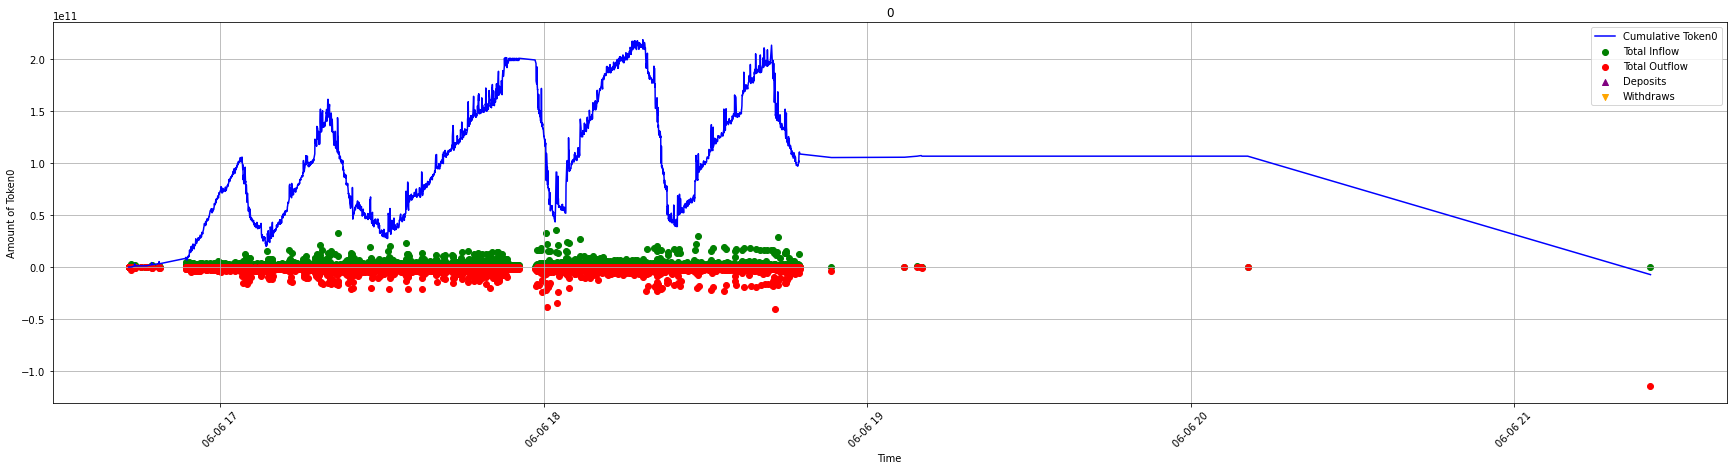

'58YzzWZ1UYsgu4rBG82ArUmV9762NfruwYZeV1sKBoWy_transactions.xlsx'

In [22]:
df = read(files[8])
data, filter_data = process_transaction_data(df)
plot_inflow_outflow(data, filter_data, 0)
files[9]

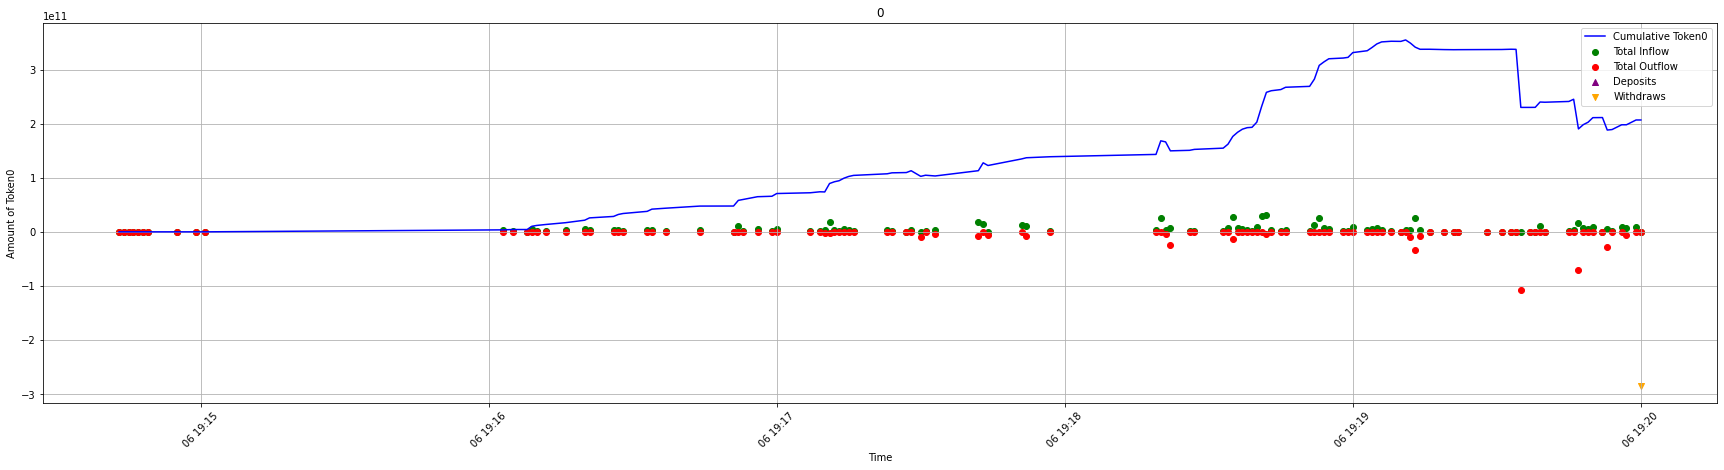

In [1]:
from util import *
from backtest import *
import logging

SELL_MIN_VAL = 1000000 # 0.001 sol
FEE = 300000 # 0.0003 sol
class SellOnFallStrategy:
    def __init__(self, init_value, sell_map):
        self.init_value = init_value
        self.nsol = 0
        self.ntoken = 0
        self.my_orders = []
        self.sell = []
        self.max_sol = 0
        self.sell_map = sell_map
        self.my_sol = 0
        self.end = False
    def init_process(self, nsol, ntoken):
        self.nsol = nsol
        self.ntoken = ntoken
        self.prev_sol = nsol # prev tick
        self.my_token = 0
        self.max_sol = self.nsol

    def on_price(self, token0, token1):
        self.nsol = token0
        self.ntoken = token1

    def on_tick(self, time):
        if self.end:
            return
        if self.my_token == 0: 
            # the first buy
            self.my_token += swap_token_amount_base_in(self.init_value, self.nsol, self.ntoken, True)
            logging.info(f"buy {self.init_value} : {self.my_token} : {time} : {self.nsol} : {self.ntoken}")
            if self.my_token == 0:
                self.end = True
            self.my_sol = -self.init_value
            self.init_my_token = self.my_token
            self.my_orders.append((time, -self.init_value, self.my_token))
        if self.nsol > self.max_sol:
            self.max_sol = self.nsol
            self.init_my_token = self.my_token #update here
        if self.prev_sol <= self.nsol or self.my_token == 0:
            self.prev_sol = self.nsol
            return
        ratio_prev, ratio_cur = 1 - self.prev_sol / self.max_sol, 1 - self.nsol / self.max_sol
        #print(f"{ratio_prev}:{ratio_cur}")
        for i in range(len(self.sell_map)):
            if ratio_prev < self.sell_map[i][0]:
                prev_idx = i
                break
        cur_idx = len(self.sell_map)
        for i in range(len(self.sell_map)):
            if ratio_cur < self.sell_map[i][0]:
                cur_idx = i
                break
        if prev_idx > cur_idx:
            return
        sell_ratio = 0
        for i in range(prev_idx, cur_idx):
            sell_ratio += self.sell_map[i][1]
        sell_out_token = int(sell_ratio * self.init_my_token)
        in_sol = swap_token_amount_base_in(sell_out_token, self.nsol, self.ntoken, False)
        if in_sol < SELL_MIN_VAL:
            sell_out_token = self.my_token
            in_sol = swap_token_amount_base_in(sell_out_token, self.nsol, self.ntoken, False)
        self.my_sol += in_sol - FEE
        self.my_token -= sell_out_token
        if self.my_token <= 10:
            self.end = True
        self.my_orders.append((time, in_sol, -sell_out_token))
        logging.info(f"sell {in_sol}:{-sell_out_token} :{self.my_token} : {time}")

if __name__ == "__main__":
    logging.basicConfig(level=logging.INFO, filename="fall_logs.txt", format='%(asctime)s|%(name)s|%(levelname)s|%(message)s',datefmt='%d-%b-%y %I:%M:%S %p')
    files = os.listdir(folder_path)
    result = {}
    init_val = [5000000, 10000000, 20000000, 40000000, 80000000]
    sell_maps = [[(0.1, 1)], 
                 [(0.2, 1)], 
                 [(0.3, 1)], 
                 [(0.4, 1)], 
                 [(0.5, 1)], 
                 [(0.6, 1)], 
                 [(0.1, 0.5), (0.2, 0.5)], 
                 [(0.1, 0.3), (0.2, 0.3), (0.3, 0.4)], 
                 [(0.1, 0.2), (0.2, 0.2), (0.3, 0.2), (0.4, 0.2), (0.5, 0.2)]]
    for i in range(len(init_val)):
        for j in range(len(sell_maps)):
            result[(i, j)] = []
    for filename in files:
        try:
            df = read(filename)
            df['time'] = pd.to_datetime(df['time'], unit='s', errors='coerce')  # 确保时间戳正确
            df = df.dropna(subset=['time'])  # 移除无效时间戳
            for i in range(len(init_val)):
                for j in range(len(sell_maps)):
                    #data, filter_data = process_transaction_data(df)
                    strategy = SellOnFallStrategy(init_val[i], sell_maps[j]) # 0.02sol
                    out_sol, strategy_orders = backtest(strategy, df)
                    #plot_inflow_outflow(data, filter_data, "Inflow and Outflow with Strategy Orders", strategy_orders)
                    result[(i, j)].append((filename, strategy.my_sol))
                    logging.info(f"strategy end {i}, {j}, {filename}: {strategy.my_sol}")
                    #orders.append((filename, strategy.my_orders))
        except:
            continue
    for i in range(len(init_val)):
        for j in range(len(sell_maps)):
            sum = 0
            for x in result[(i, j)]:
                sum += x[1]
            logging.info(f"{i}, {j}: {sum}")

In [24]:
row['Token0']

113998993571

In [26]:
strategy.my_sol

1136609209

GRaUN4sTAtrVUcpRWSxHL6BtN84cjSVjCryCspitx5zf_transactions.xlsx
{'amm_id': Pubkey(
    GRaUN4sTAtrVUcpRWSxHL6BtN84cjSVjCryCspitx5zf,
), 'base_mint': Pubkey(
    4zA8v8dDjPzscQfQVQWxGw6X8ejaR79YjWkuf9rGR96o,
), 'quote_mint': Pubkey(
    So11111111111111111111111111111111111111112,
), 'lp_mint': Pubkey(
    Fp1VsZMpnNobyzbdXU4k9vBgAMusMh1WEpGWfLhYikB6,
), 'version': 4, 'base_decimals': 6, 'quote_decimals': 9, 'lpDecimals': 6, 'programId': Pubkey(
    675kPX9MHTjS2zt1qfr1NYHuzeLXfQM9H24wFSUt1Mp8,
), 'authority': Pubkey(
    5Q544fKrFoe6tsEbD7S8EmxGTJYAKtTVhAW5Q5pge4j1,
), 'open_orders': Pubkey(
    DchfPtm1TSvhGQbmXGDFnCtTWfR19XBzpkcTpu1PxN8s,
), 'target_orders': Pubkey(
    CoBQmDWuQjo85yE8RX8bLWzWCBNBVZL3wo7Fcd3JYCHy,
), 'base_vault': Pubkey(
    FG1mzGC8Vu9EoxdZTKYhues83QNdRBJMgb6y3B8GLfSA,
), 'quote_vault': Pubkey(
    RLTQ5vQBWywEpfduzoHVKNaTr64NZNCM4kiowkVHTmX,
), 'withdrawQueue': Pubkey(
    11111111111111111111111111111111,
), 'lpVault': Pubkey(
    11111111111111111111111111111111

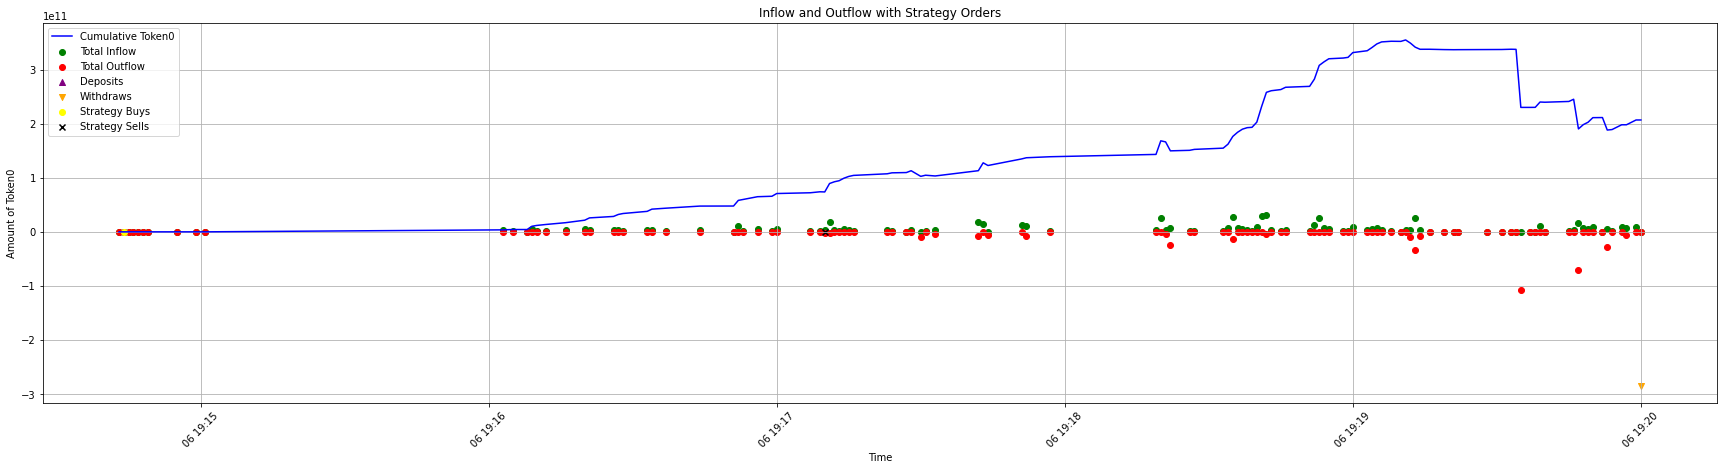

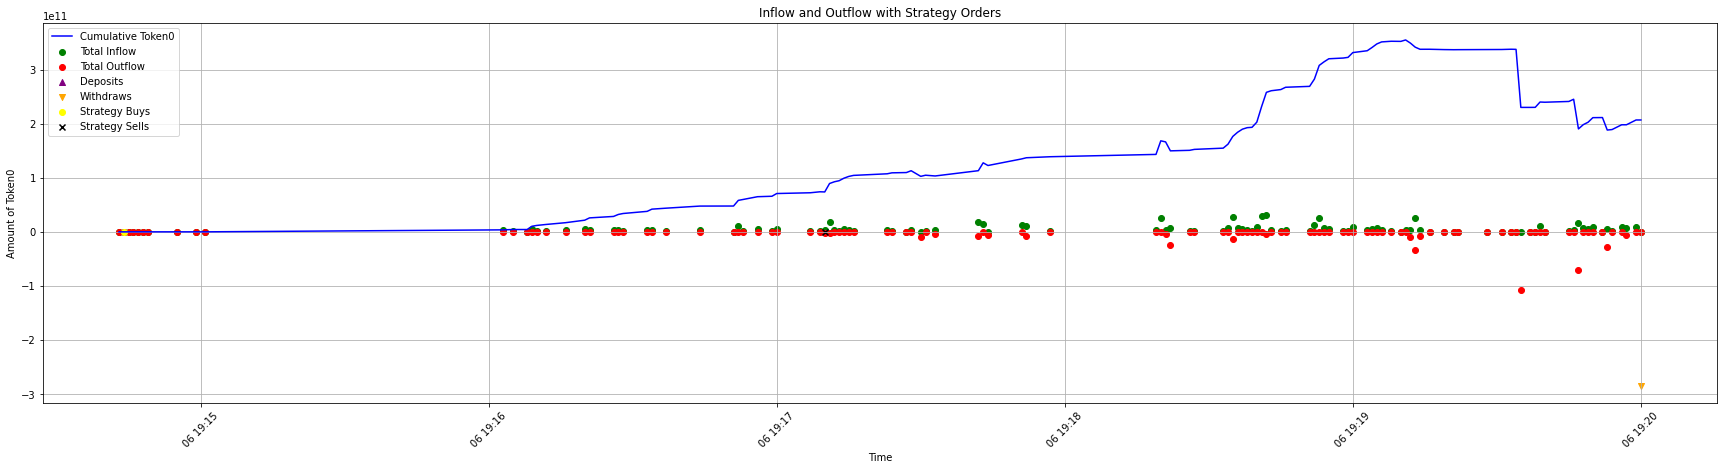

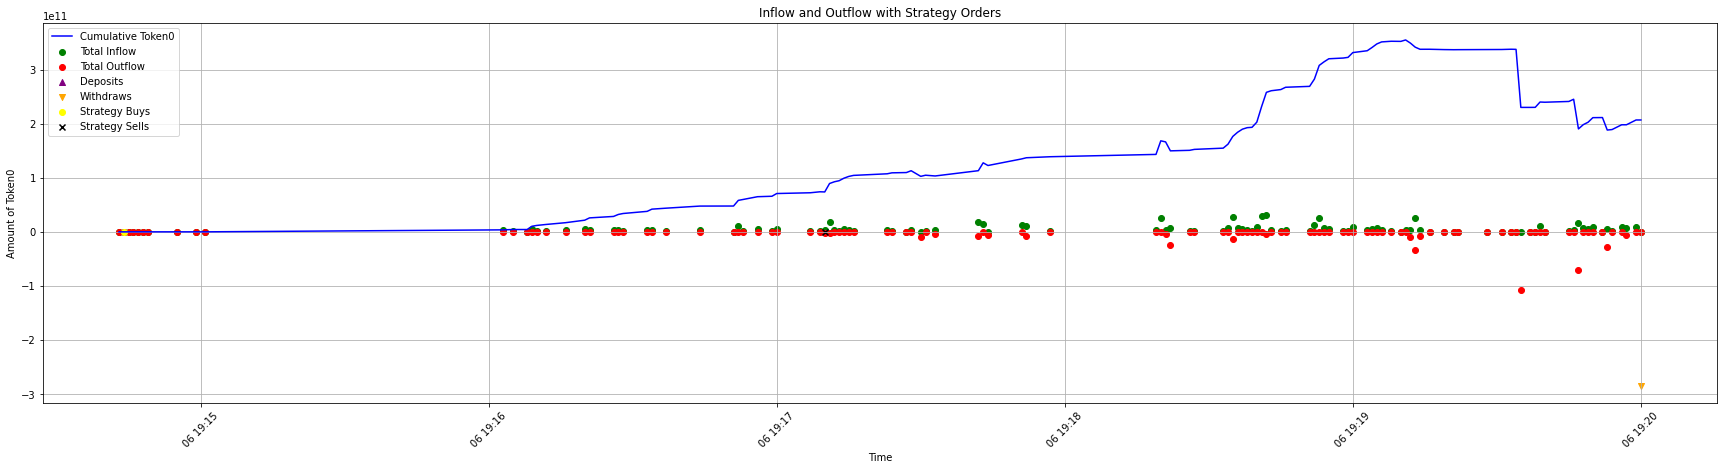

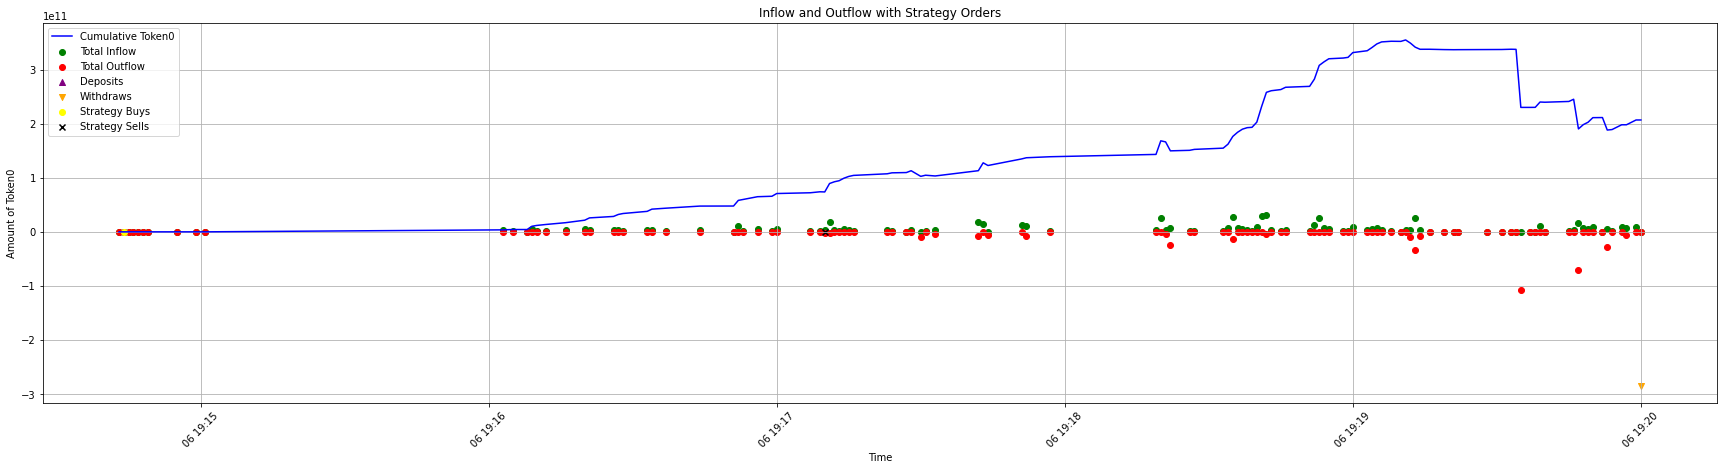

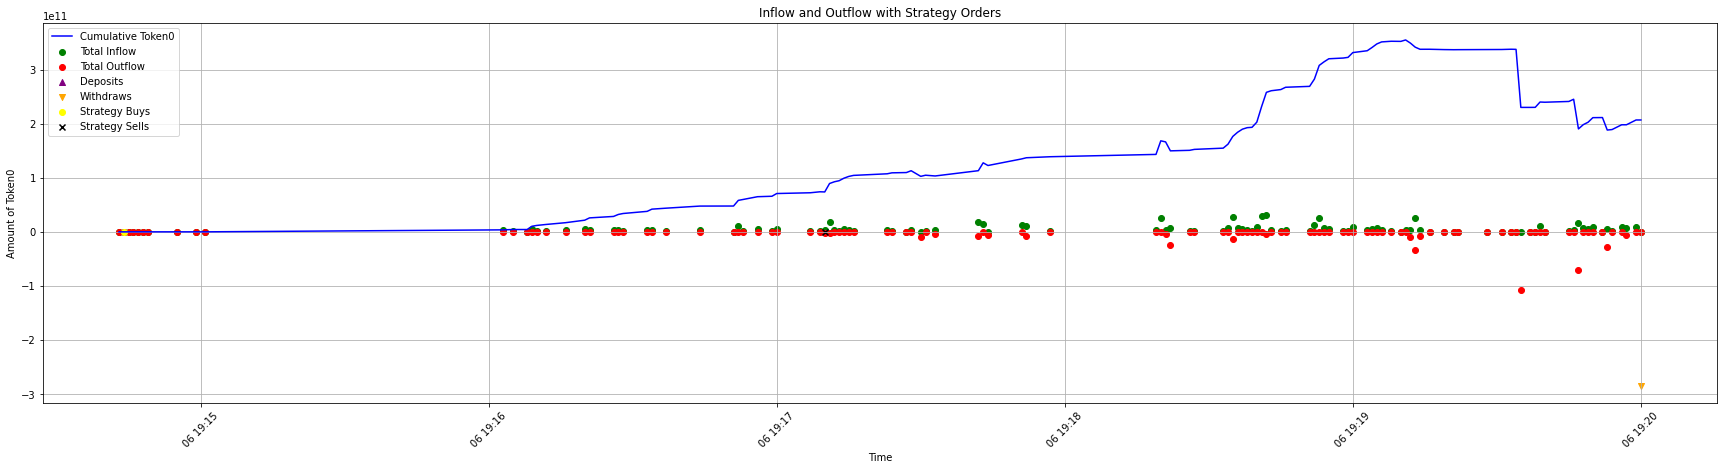

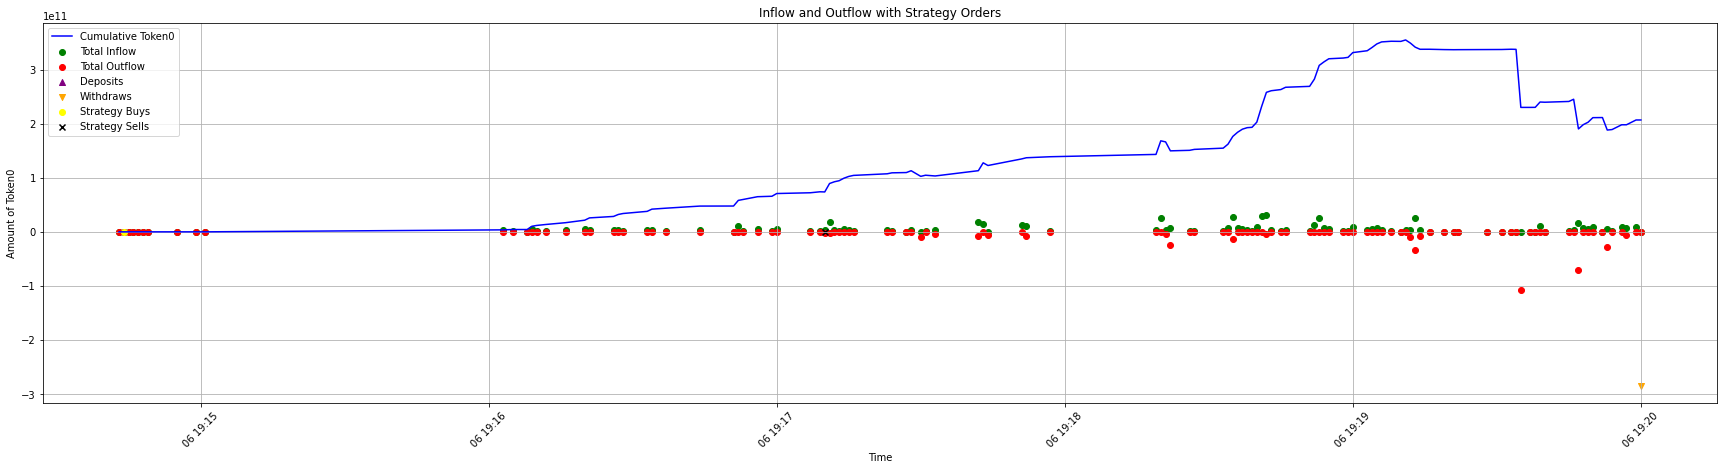

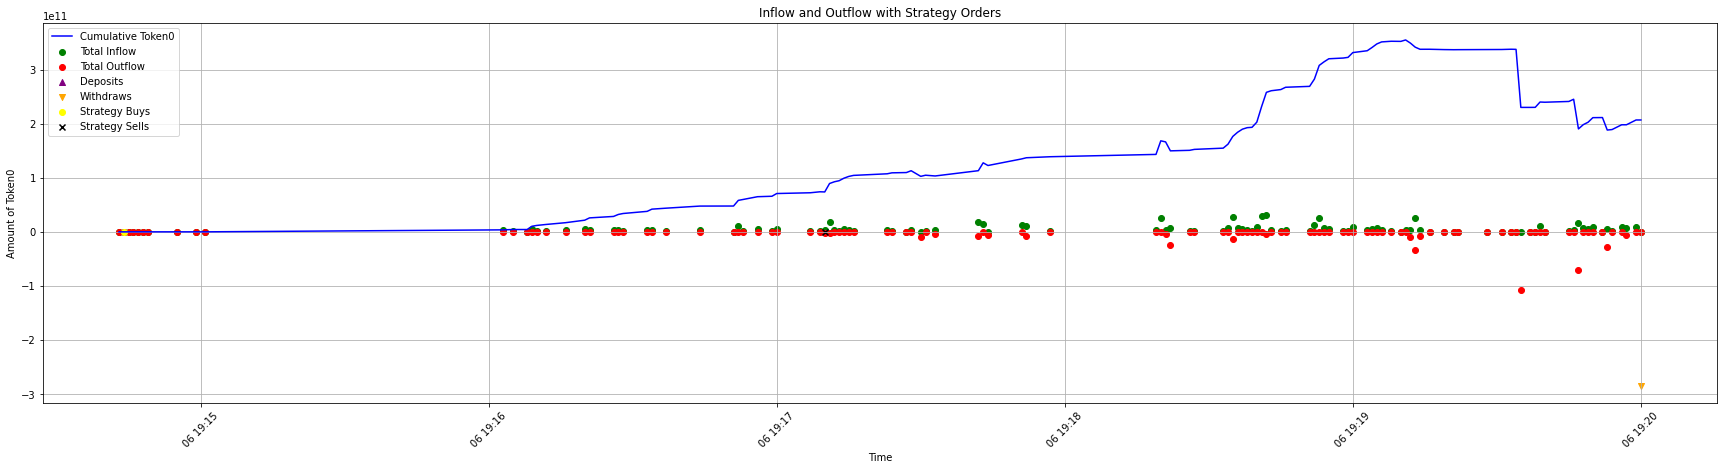

WRm6pkSmiai28635u4eqyrPeB5vyNPQZo8qauKSgDsA_transactions.xlsx
{'amm_id': Pubkey(
    WRm6pkSmiai28635u4eqyrPeB5vyNPQZo8qauKSgDsA,
), 'base_mint': Pubkey(
    g5L8Ats4dskouBB1FS7xXXQ3jaK9Sr7ojuRbgpSXLpg,
), 'quote_mint': Pubkey(
    So11111111111111111111111111111111111111112,
), 'lp_mint': Pubkey(
    FZk6o9tpjJ5f1sh62A7fcJEnCGNDgr1g4v1uEc1fDok5,
), 'version': 4, 'base_decimals': 6, 'quote_decimals': 9, 'lpDecimals': 6, 'programId': Pubkey(
    675kPX9MHTjS2zt1qfr1NYHuzeLXfQM9H24wFSUt1Mp8,
), 'authority': Pubkey(
    5Q544fKrFoe6tsEbD7S8EmxGTJYAKtTVhAW5Q5pge4j1,
), 'open_orders': Pubkey(
    9iMQCD2TWshbJecegNM97Ux68fcs91Y4GNvAyvCskTr4,
), 'target_orders': Pubkey(
    2LsERuWYdzPCXNuvcKPBL5FQnj4Ewa56e3wkj6QBwgoU,
), 'base_vault': Pubkey(
    GyqrcBF6n5LUoGLzC7H915gTpAHmC9h9vZXE8Gj8YpAj,
), 'quote_vault': Pubkey(
    2yQ67qmMhVUZPSRNBjujmVYZu5XJsZcNERdwLqEBKeNQ,
), 'withdrawQueue': Pubkey(
    11111111111111111111111111111111,
), 'lpVault': Pubkey(
    11111111111111111111111111111111,


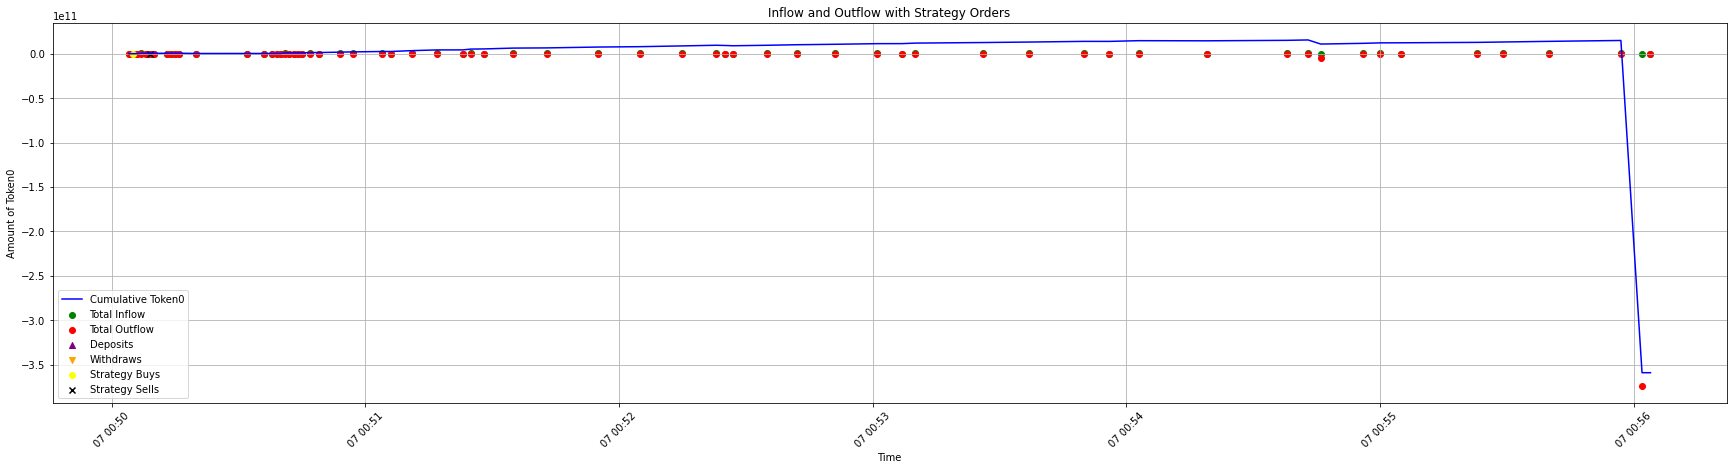

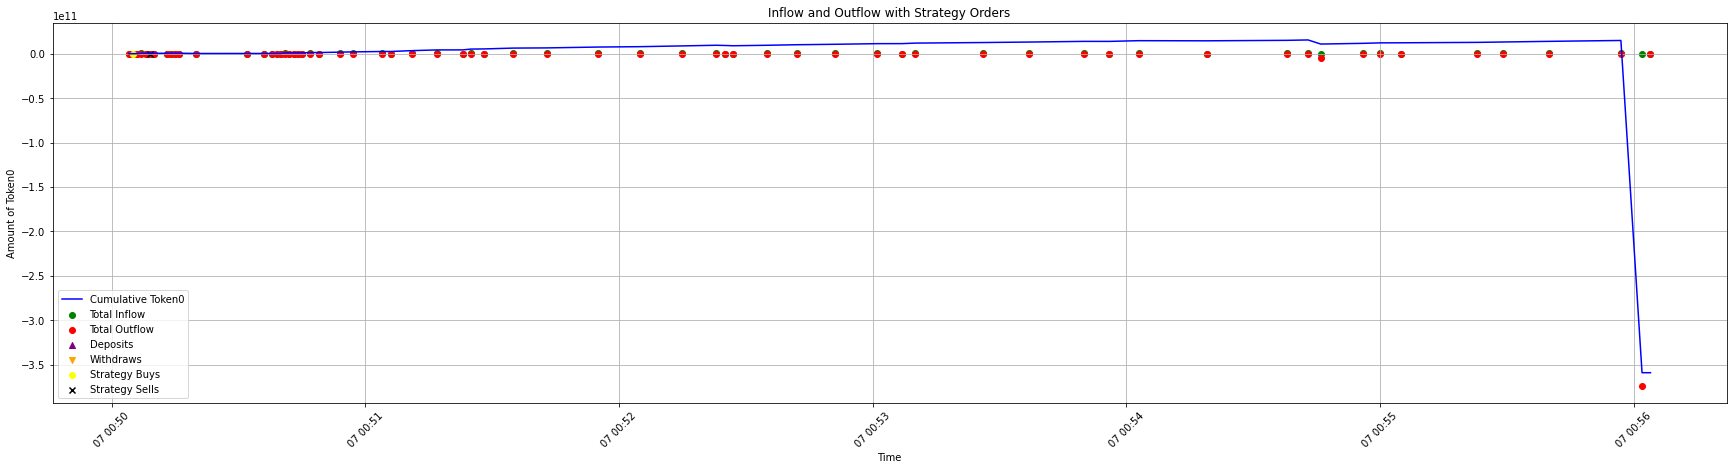

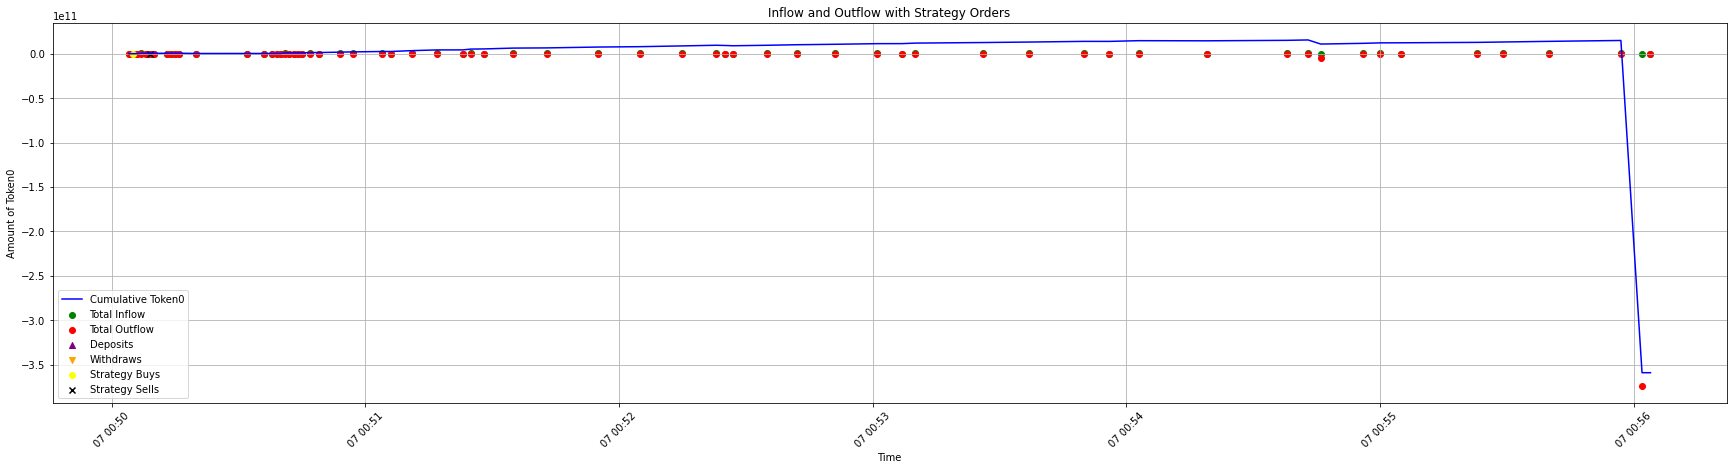

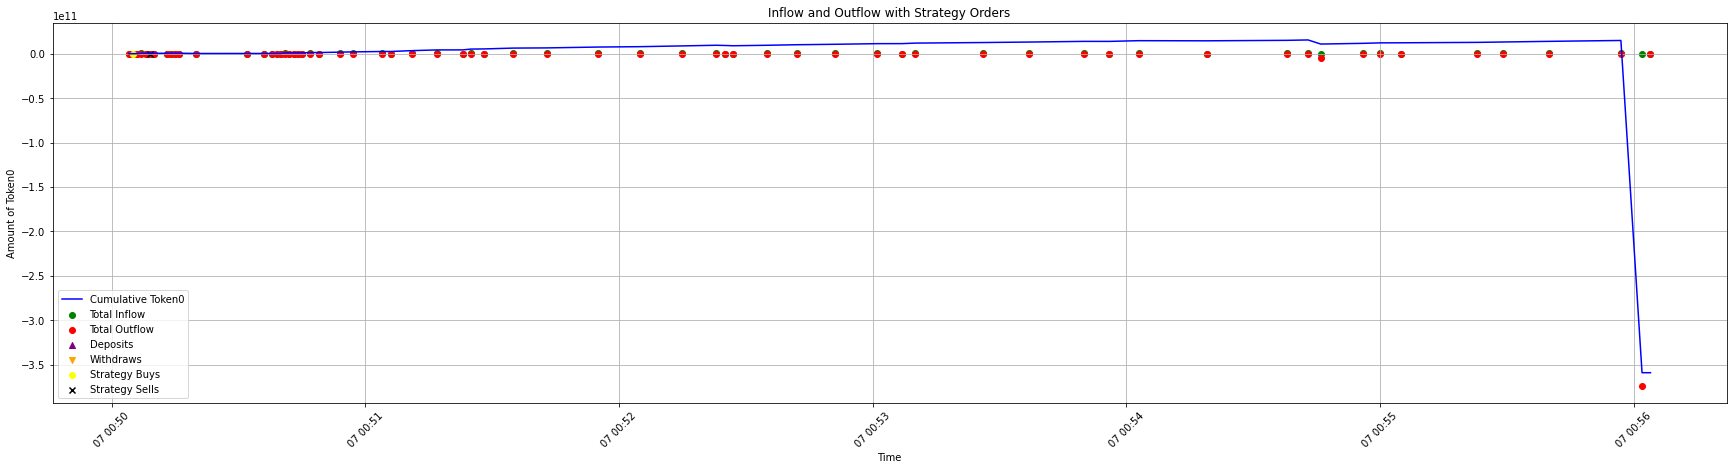

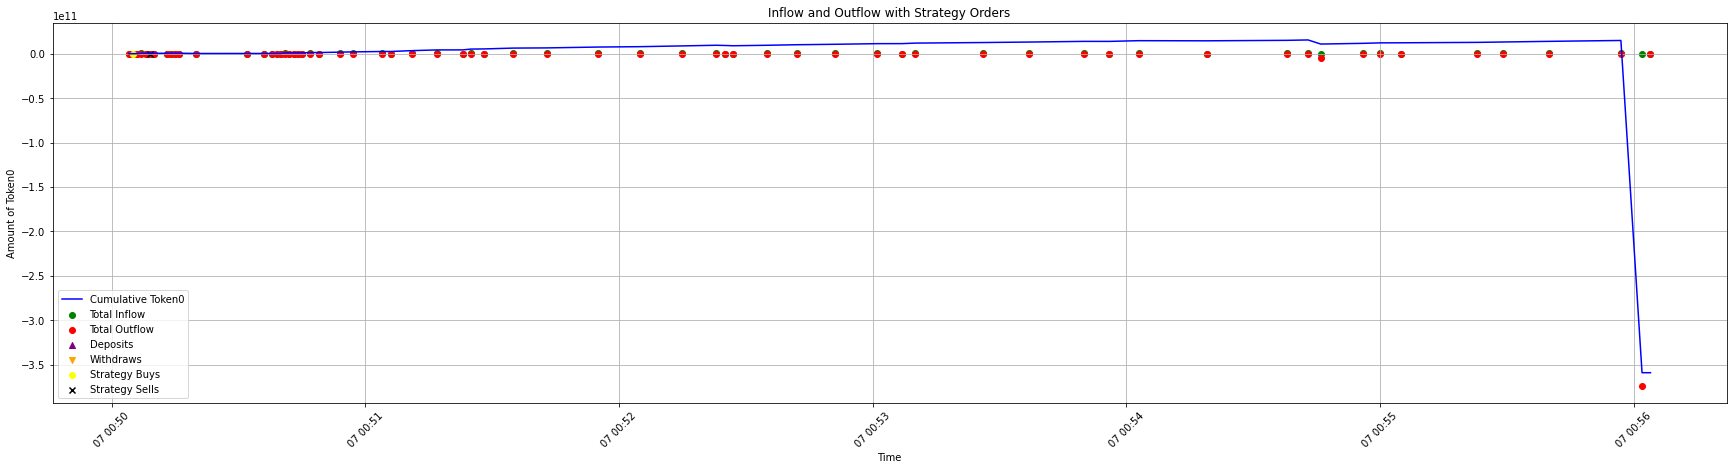

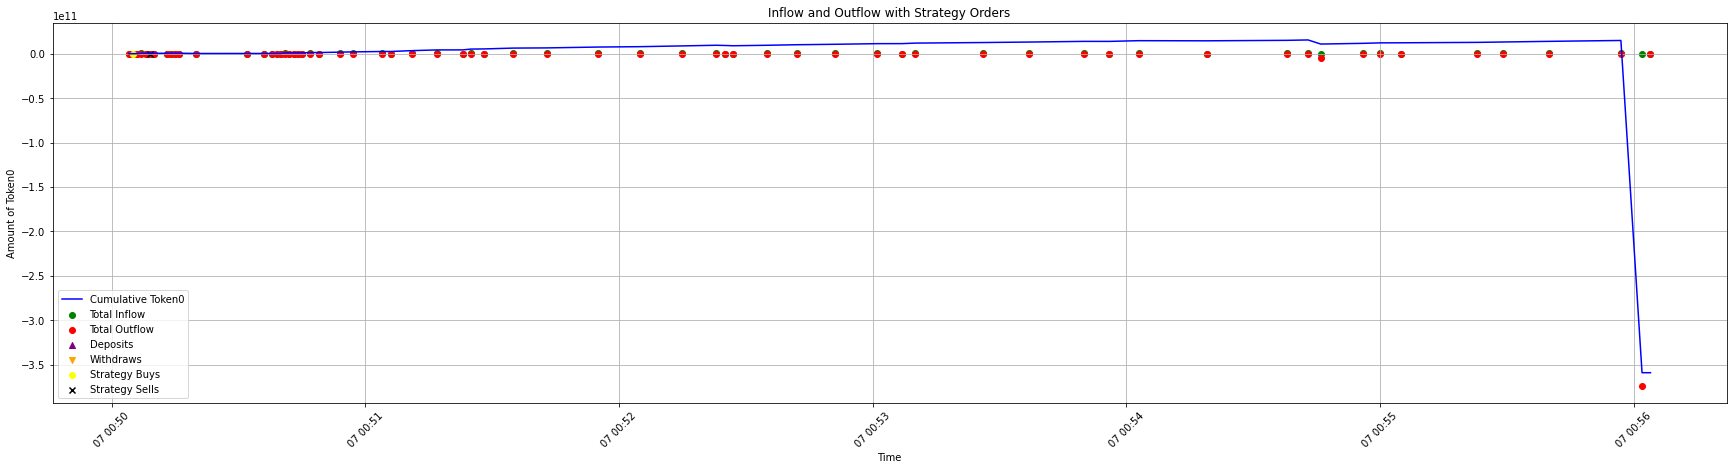

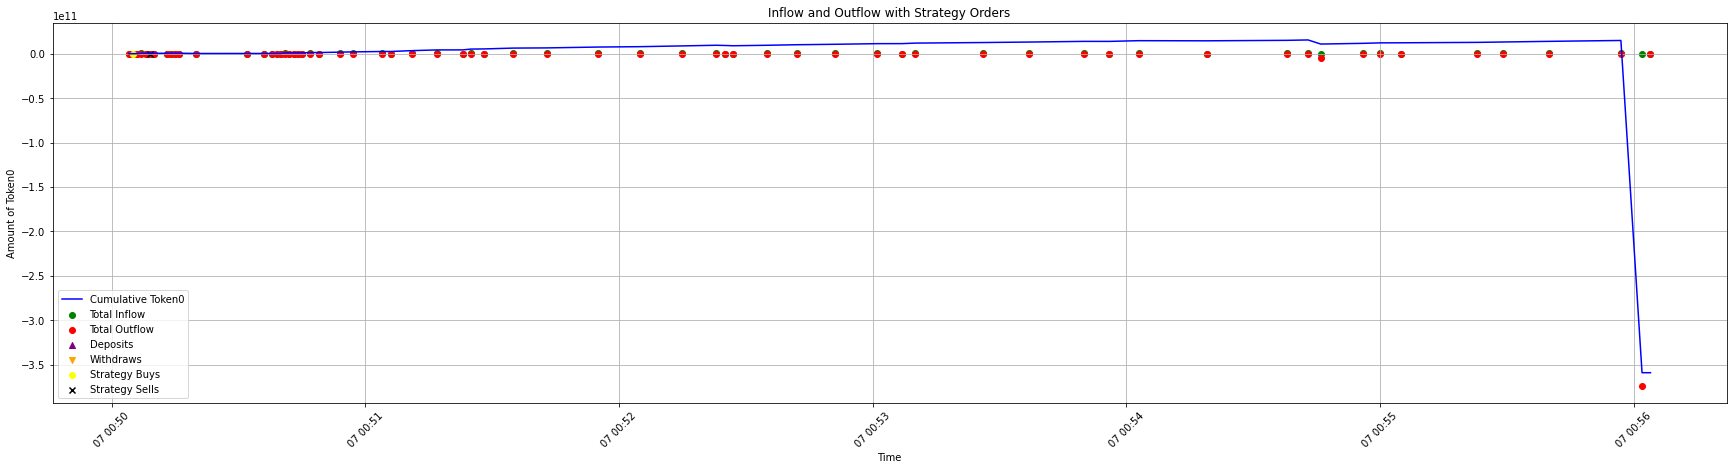

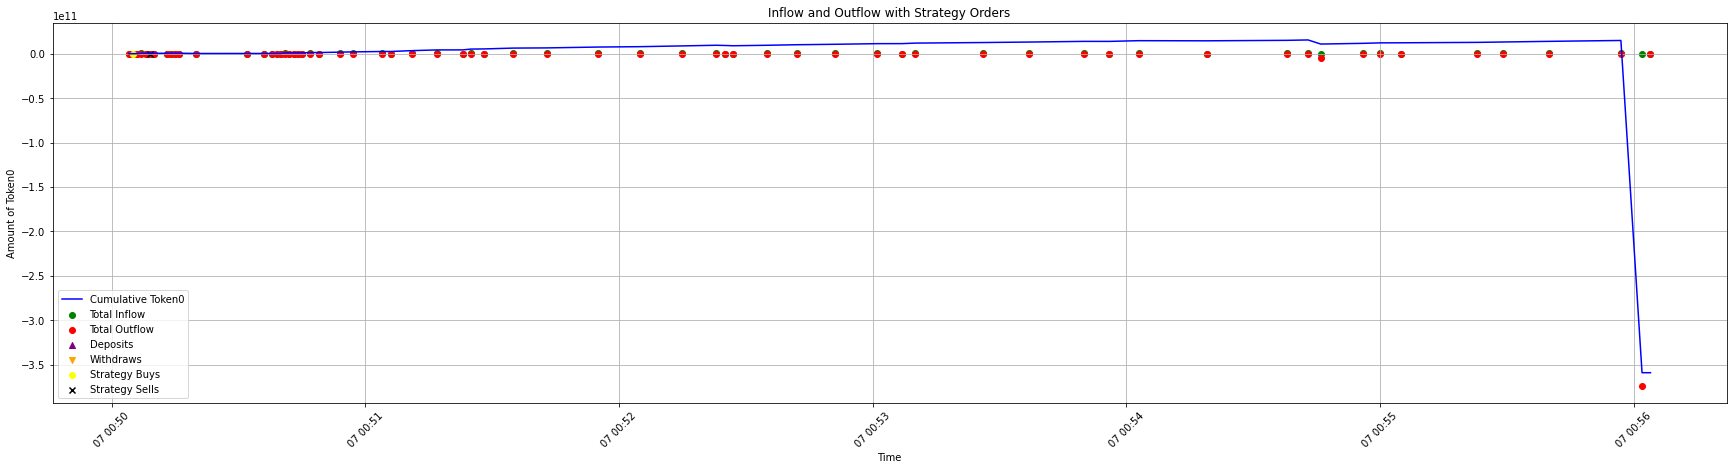

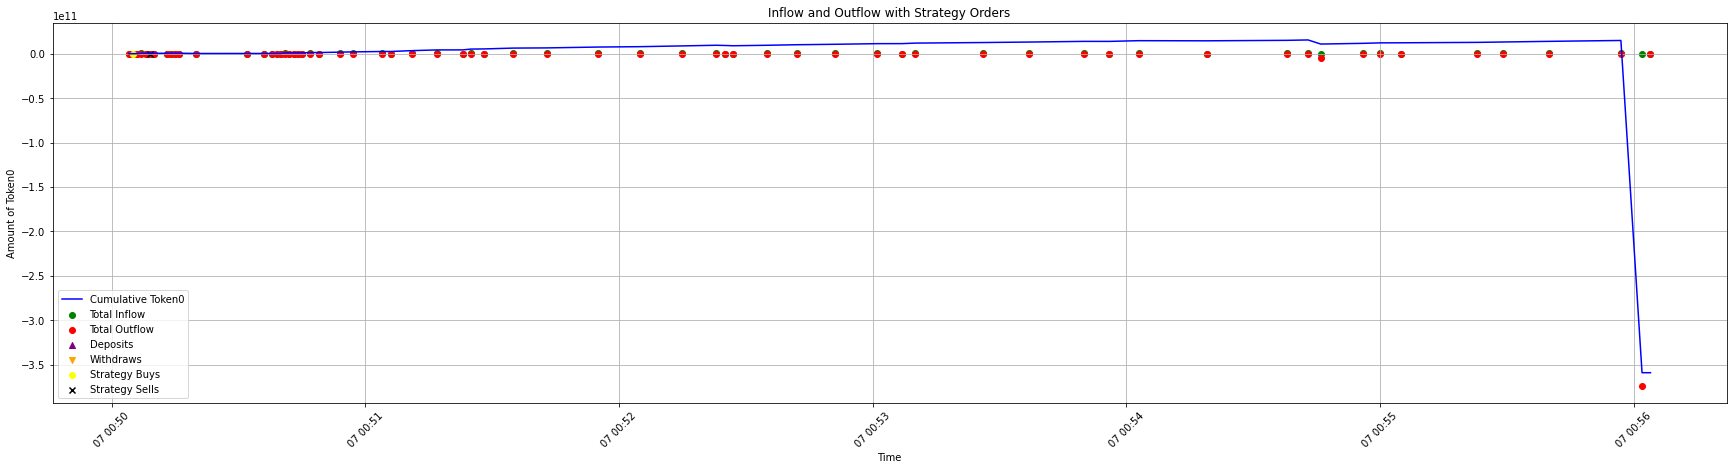

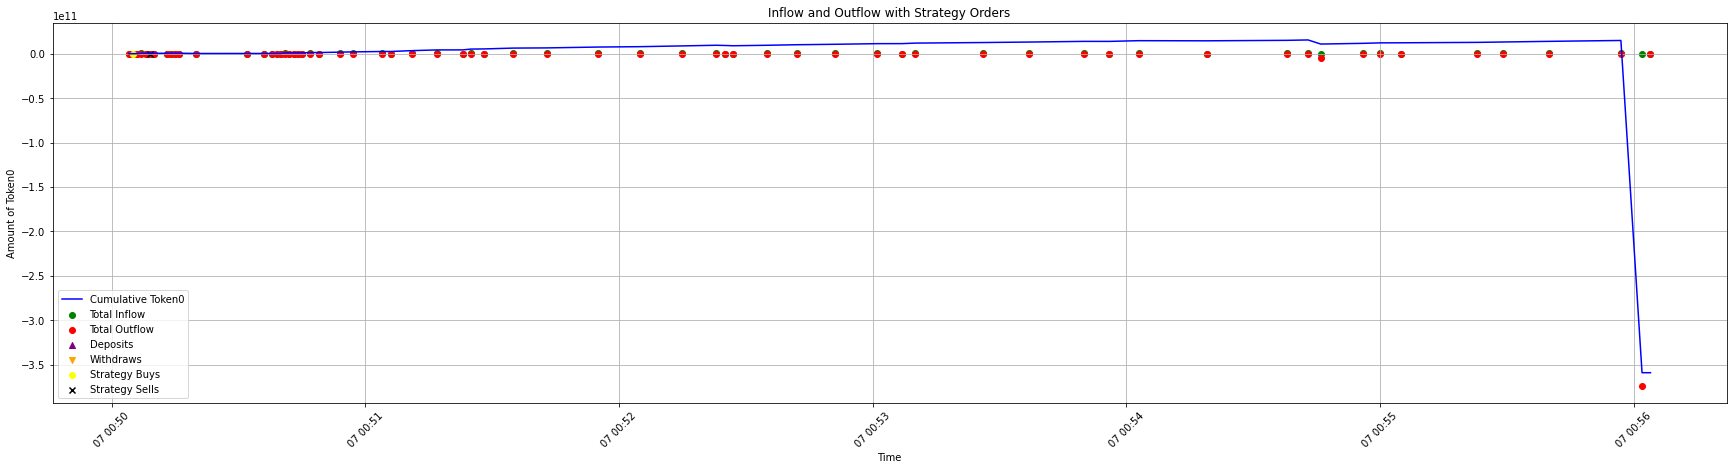

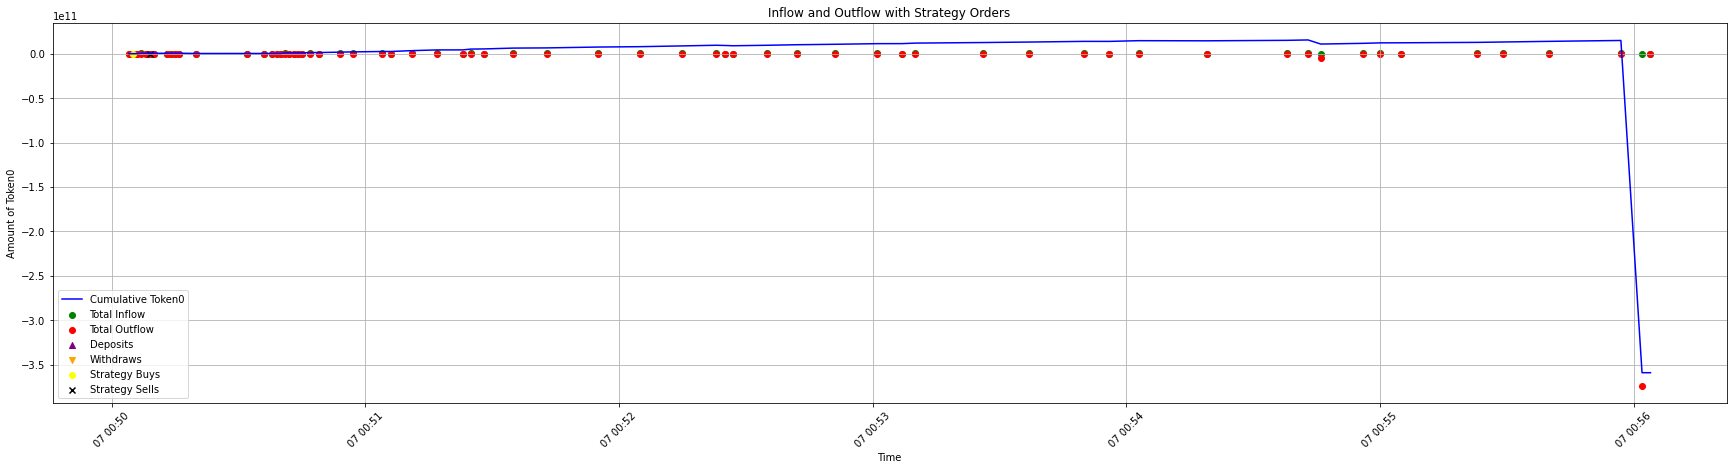

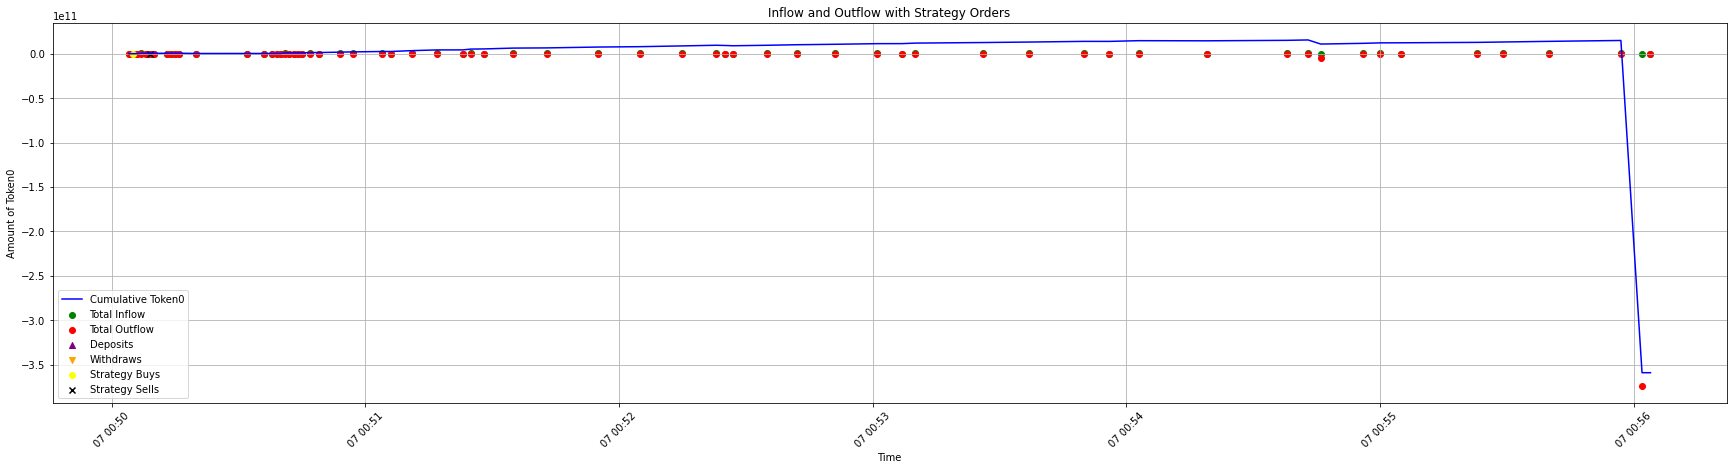

In [1]:
from util import *
from backtest import *
import logging

SELL_MIN_VAL = 1000000 # 0.001 sol
FEE = 300000 # 0.0003 sol
class SellOnFallStrategy:
    def __init__(self, init_value, sell_map):
        self.init_value = init_value
        self.nsol = 0
        self.ntoken = 0
        self.my_orders = []
        self.sell = []
        self.max_sol = 0
        self.sell_map = sell_map
        self.my_sol = 0
        self.end = False
    def init_process(self, nsol, ntoken):
        self.nsol = nsol
        self.ntoken = ntoken
        self.prev_sol = nsol # prev tick
        self.my_token = 0
        self.max_sol = self.nsol

    def on_price(self, token0, token1):
        self.nsol = token0
        self.ntoken = token1

    def on_tick(self, time):
        if self.end:
            return
        if self.my_token == 0: 
            # the first buy
            self.my_token += swap_token_amount_base_in(self.init_value, self.nsol, self.ntoken, True)
            logging.info(f"buy {self.init_value} : {self.my_token} : {time} : {self.nsol} : {self.ntoken}")
            if self.my_token == 0:
                self.end = True
            self.my_sol = -self.init_value
            self.init_my_token = self.my_token
            self.my_orders.append((time, -self.init_value, self.my_token))
        if self.nsol > self.max_sol:
            self.max_sol = self.nsol
            self.init_my_token = self.my_token #update here
        if self.prev_sol <= self.nsol or self.my_token == 0:
            self.prev_sol = self.nsol
            return
        ratio_prev, ratio_cur = 1 - self.prev_sol / self.max_sol, 1 - self.nsol / self.max_sol
        #print(f"{ratio_prev}:{ratio_cur}")
        for i in range(len(self.sell_map)):
            if ratio_prev < self.sell_map[i][0]:
                prev_idx = i
                break
        cur_idx = len(self.sell_map)
        for i in range(len(self.sell_map)):
            if ratio_cur < self.sell_map[i][0]:
                cur_idx = i
                break
        if prev_idx > cur_idx:
            return
        sell_ratio = 0
        for i in range(prev_idx, cur_idx):
            sell_ratio += self.sell_map[i][1]
        sell_out_token = int(sell_ratio * self.init_my_token)
        in_sol = swap_token_amount_base_in(sell_out_token, self.nsol, self.ntoken, False)
        if in_sol < SELL_MIN_VAL:
            sell_out_token = self.my_token
            in_sol = swap_token_amount_base_in(sell_out_token, self.nsol, self.ntoken, False)
        self.my_sol += in_sol - FEE
        self.my_token -= sell_out_token
        if self.my_token <= 10:
            self.end = True
        self.my_orders.append((time, in_sol, -sell_out_token))
        logging.info(f"sell {in_sol}:{-sell_out_token} :{self.my_token} : {time}")

logging.basicConfig(level=logging.INFO, filename="fall_logs.txt", format='%(asctime)s|%(name)s|%(levelname)s|%(message)s',datefmt='%d-%b-%y %I:%M:%S %p')
files = os.listdir(folder_path)
result = {}
init_val = [5000000, 10000000, 20000000, 40000000, 80000000]
sell_maps = [[(0.1, 1)], 
                [(0.2, 1)], 
                [(0.3, 1)], 
                [(0.4, 1)], 
                [(0.5, 1)], 
                [(0.6, 1)], 
                [(0.1, 0.5), (0.2, 0.5)], 
                [(0.1, 0.3), (0.2, 0.3), (0.3, 0.4)], 
                [(0.1, 0.2), (0.2, 0.2), (0.3, 0.2), (0.4, 0.2), (0.5, 0.2)]]
for i in range(len(init_val)):
    for j in range(len(sell_maps)):
        result[(i, j)] = []
for filename in files:
    try:
        print(filename)
        df = read(filename)
        df['time'] = pd.to_datetime(df['time'], unit='s', errors='coerce')  # 确保时间戳正确
        df = df.dropna(subset=['time'])  # 移除无效时间戳
        for i in range(len(init_val)):
            for j in range(len(sell_maps)):
                data, filter_data = process_transaction_data(df)
                strategy = SellOnFallStrategy(init_val[i], sell_maps[j]) # 0.02sol
                out_sol, strategy_orders = backtest(strategy, df)
                plot_inflow_outflow(data, filter_data, "Inflow and Outflow with Strategy Orders", strategy_orders)
                result[(i, j)].append((filename, strategy.my_sol))
                logging.info(f"strategy end {i}, {j}, {filename}: {strategy.my_sol}")
    except:
        continue
for i in range(len(init_val)):
    for j in range(len(sell_maps)):
        sum = 0
        for x in result[(i, j)]:
            sum += x[1]
        logging.info(f"{i}, {j}: {sum}")

In [7]:
strategy.my_sol

-8409809

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict
from util import fetch_pool_keys, SOL, swap_token_amount_base_in
# 定义处理交易数据的函数
def process_transaction_data(df):
    data = df.copy()

    # Convert timestamps
    data['time'] = pd.to_datetime(data['time'], unit='s', errors='coerce')
    data = data.dropna(subset=['time'])  # 移除无效时间戳
    data = data.sort_values('time')

    # Label buy and sell orders
    data['type'] = data.apply(lambda row: 'buy' if row['Delta0'] > 0 and row['Delta1'] < 0 else 'sell' if row['Delta0'] < 0 and row['Delta1'] > 0 else 'Deposit' if row['Delta0'] > 0 and row['Delta1'] > 0 else 'Withdraw', axis=1)

    # Function to detect sandwich orders
    def is_sandwich(group):
        buy_orders = group[group['type'] == 'buy']['Delta0'].sum()
        sell_orders = group[group['type'] == 'sell']['Delta0'].sum()
        if sell_orders == 0:
            return False
        ratio = buy_orders / abs(sell_orders)
        return 0.9 <= ratio <= 1.1 and buy_orders > 1e10

    # Filter out sandwich orders
    filtered_data = data.groupby(['time', 'From']).filter(lambda group: not is_sandwich(group))
    
    # Calculate VWAP prices
    buy_orders = filtered_data[filtered_data['type'] == 'buy'].copy()
    sell_orders = filtered_data[filtered_data['type'] == 'sell'].copy()

    buy_orders['vwap'] = buy_orders['Delta0'] / abs(buy_orders['Delta1'])
    sell_orders['vwap'] = abs(sell_orders['Delta0']) / abs(sell_orders['Delta1'])

    buy_vwap = buy_orders.groupby('time').apply(lambda x: (x['vwap'] * abs(x['Delta0'])).sum() / abs(x['Delta0']).sum()).reset_index()
    buy_vwap.columns = ['time', 'buy_vwap']

    sell_vwap = sell_orders.groupby('time').apply(lambda x: (x['vwap'] * abs(x['Delta0'])).sum() / abs(x['Delta0']).sum()).reset_index()
    sell_vwap.columns = ['time', 'sell_vwap']

    # Merge buy and sell VWAP prices
    order_vwap = pd.merge(buy_vwap, sell_vwap, on='time', how='outer')
    order_vwap['order_vwap'] = (order_vwap['buy_vwap'].fillna(0) + order_vwap['sell_vwap'].fillna(0)) / 2

    # Calculate pool price
    filtered_data['pool_price'] = filtered_data['Token0'] / filtered_data['Token1']

    # Calculate total inflow and outflow of Token0
    inflow = buy_orders.groupby('time')['Delta0'].sum().reset_index()
    inflow.columns = ['time', 'total_inflow']

    outflow = sell_orders.groupby('time')['Delta0'].sum().reset_index()
    outflow.columns = ['time', 'total_outflow']

    # Get unique time points for pool prices
    pool_data = filtered_data.drop_duplicates(subset=['time']).sort_values(by='time')

    # Merge VWAP, pool price, inflow, and outflow data
    merged_data = pd.merge(order_vwap[['time', 'order_vwap']], pool_data[['time', 'pool_price']], on='time', how='outer')
    merged_data = pd.merge(merged_data, inflow, on='time', how='outer')
    merged_data = pd.merge(merged_data, outflow, on='time', how='outer')

    # Ensure unique time points
    merged_data = merged_data.drop_duplicates(subset=['time'])
    merged_data = merged_data.fillna(0)

    return merged_data, filtered_data

# 定义绘图函数
def plot_inflow_outflow(data, filtered_data, title, strategy_orders):
    # Group by time to ensure unique timestamps and sum the values
    aggregated_data = data.groupby('time').agg({
        'total_inflow': 'sum',
        'total_outflow': 'sum'
    }).reset_index()

    # 计算Token0的累积量
    aggregated_data['cumulative_token0'] = aggregated_data['total_inflow'].cumsum() + aggregated_data['total_outflow'].cumsum()

    plt.figure(figsize=(30, 7))

    # Plot total inflow as scatter plot
    plt.scatter(aggregated_data['time'], aggregated_data['total_inflow'], label='Total Inflow', color='green')

    # Plot total outflow as scatter plot
    plt.scatter(aggregated_data['time'], aggregated_data['total_outflow'], label='Total Outflow', color='red')

    # Plot cumulative Token0 amount as a line plot
    plt.plot(aggregated_data['time'], aggregated_data['cumulative_token0'], label='Cumulative Token0', color='blue')

    # Plot deposits and withdraws as scatter plots
    deposits = filtered_data[filtered_data['type'] == 'Deposit']
    withdraws = filtered_data[filtered_data['type'] == 'Withdraw']
    
    plt.scatter(deposits['time'], deposits['Delta0'], label='Deposits', color='purple', marker='^')
    plt.scatter(withdraws['time'], withdraws['Delta0'], label='Withdraws', color='orange', marker='v')

    # Plot strategy buy and sell orders
    buy_orders = [order for order in strategy_orders if order[1] < 0]
    sell_orders = [order for order in strategy_orders if order[1] > 0]
    
    plt.scatter([order[0] for order in buy_orders], [order[1] for order in buy_orders], label='Strategy Buys', color='yellow', marker='o')
    plt.scatter([order[0] for order in sell_orders], [order[1] for order in sell_orders], label='Strategy Sells', color='black', marker='x')

    # Customize the plot
    plt.xlabel('Time')
    plt.ylabel('Amount of Token0')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    
    # Show plot
    plt.show()

class BaseStrategy:
    def __init__(self, init_value):
        self.init_value = init_value
        self.nsol = 0
        self.ntoken = 0
        self.my_orders = []

    def init_process(self):
        pass

    def on_price(self, token0, token1):
        pass

    def on_tick(self, diff_seconds=1):
        pass
    
def backtest(strategy, df):
    data = df.copy()
    strategy.init_process(data['Token0'][0], data['Token1'][0])
    prev_time = data['time'][0]
    for t_row in data.iterrows():
        row = t_row[1]
        if row['time'] != prev_time:
            strategy.on_tick(row['time'])
        cur_token0 = row['Token0'] + row['Delta0']
        cur_token1 = row['Token1'] + row['Delta1']
        strategy.on_price(cur_token0, cur_token1)
    strategy.on_tick(row['time'])
    out_sol = strategy.nsol + swap_token_amount_base_in(strategy.ntoken, cur_token0, cur_token1, True)
    return out_sol, strategy.my_orders

SELL_MIN_VAL = 1000000 # 0.001 sol
FEE = 300000 # 0.0003 sol
class SnipeAndSell:
    def __init__(self, init_value):
        self.init_value = init_value
        self.nsol = 0
        self.ntoken = 0
        self.my_orders = []
        self.sell = []
        self.ignore_fluctuation_ratio = 0.05
        self.max_sol = 0
        self.sell_map = [(0.1, 0.1), (0.2, 0.1), (0.3, 0.1), (0.4, 0.1), (0.5, 0.6)]
        self.my_sol = 0
        self.end = False
    def init_process(self, nsol, ntoken):
        self.nsol = nsol
        self.ntoken = ntoken
        self.prev_sol = nsol # prev tick
        self.my_token = 0
        self.max_sol = self.nsol

    def on_price(self, token0, token1):
        self.nsol = token0
        self.ntoken = token1

    def on_tick(self, time):
        if self.end:
            return
        if self.my_token == 0: 
            # the first buy
            self.my_token += swap_token_amount_base_in(self.init_value, self.nsol, self.ntoken, True)
            print(f"buy {self.init_value} : {self.my_token} : {time} : {self.nsol} : {self.ntoken}")
            self.my_sol = -self.init_value
            self.init_my_token = self.my_token
            self.my_orders.append((time, -self.init_value, self.my_token))
        if self.nsol > self.max_sol:
            self.max_sol = self.nsol
            self.init_my_token = self.my_token #update here
        if self.prev_sol <= self.nsol or self.my_token == 0:
            self.prev_sol = self.nsol
            return
        ratio_prev, ratio_cur = 1 - self.prev_sol / self.max_sol, 1 - self.nsol / self.max_sol
        #print(f"{ratio_prev}:{ratio_cur}")
        for i in range(len(self.sell_map)):
            if ratio_prev < self.sell_map[i][0]:
                prev_idx = i
                break
        cur_idx = len(self.sell_map)
        for i in range(len(self.sell_map)):
            if ratio_cur < self.sell_map[i][0]:
                cur_idx = i
                break
        if prev_idx > cur_idx:
            return
        sell_ratio = 0
        for i in range(prev_idx, cur_idx):
            sell_ratio += self.sell_map[i][1]
        sell_out_token = int(sell_ratio * self.init_my_token)
        in_sol = swap_token_amount_base_in(sell_out_token, self.nsol, self.ntoken, False)
        if in_sol < SELL_MIN_VAL:
            sell_out_token = self.my_token
            in_sol = swap_token_amount_base_in(sell_out_token, self.nsol, self.ntoken, False)
        self.my_sol += in_sol - FEE
        self.my_token -= sell_out_token
        if self.my_token <= 10:
            self.end = True
        self.my_orders.append((time, in_sol, -sell_out_token))
        print(f"sell {in_sol}:{-sell_out_token} :{self.my_token} : {time}")

folder_path = '/Users/ekko/Downloads/coin_data'  # 更改为你的文件夹路径
files = os.listdir(folder_path)
def read(file):
    file_path = os.path.join(folder_path, file)
    df = pd.read_excel(file_path)
    data = df.copy()
    pool_address = file.split('_')[0]
    if fetch_pool_keys(pool_address)['base_mint'] != SOL:
        data['Token0'], data['Token1'] = df['Token1'], df['Token0']
        data['Delta0'], data['Delta1'] = df['Delta1'], df['Delta0']
    return data
orders = []
result = []

In [4]:
def analyze_peak_and_drawdown(data):
    data = data.sort_values(by='time')
    cumulative_data = data['total_inflow'].cumsum() + data['total_outflow'].cumsum()
    
    peak_values = []
    drawdowns = []

    peak = cumulative_data.iloc[0]
    for value in cumulative_data:
        if value > peak:
            peak = value
        drawdown = (peak - value) / peak
        peak_values.append(peak)
        drawdowns.append(drawdown)
    
    data['peak'] = peak_values
    data['drawdown'] = drawdowns
    
    return data

def plot_peak_and_drawdown(data, title):
    plt.figure(figsize=(30, 7))
    
    # Plot cumulative Token0 amount
    plt.plot(data['time'], data['total_inflow'].cumsum() + data['total_outflow'].cumsum(), label='Cumulative Token0', color='blue')
    
    # Plot peak values
    plt.plot(data['time'], data['peak'], label='Peak', color='green')
    
    # Plot drawdowns
    plt.plot(data['time'], data['drawdown'], label='Drawdown', color='red')
    
    # Customize the plot
    plt.xlabel('Time')
    plt.ylabel('Amount / Drawdown')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    
    # Show plot
    plt.show()

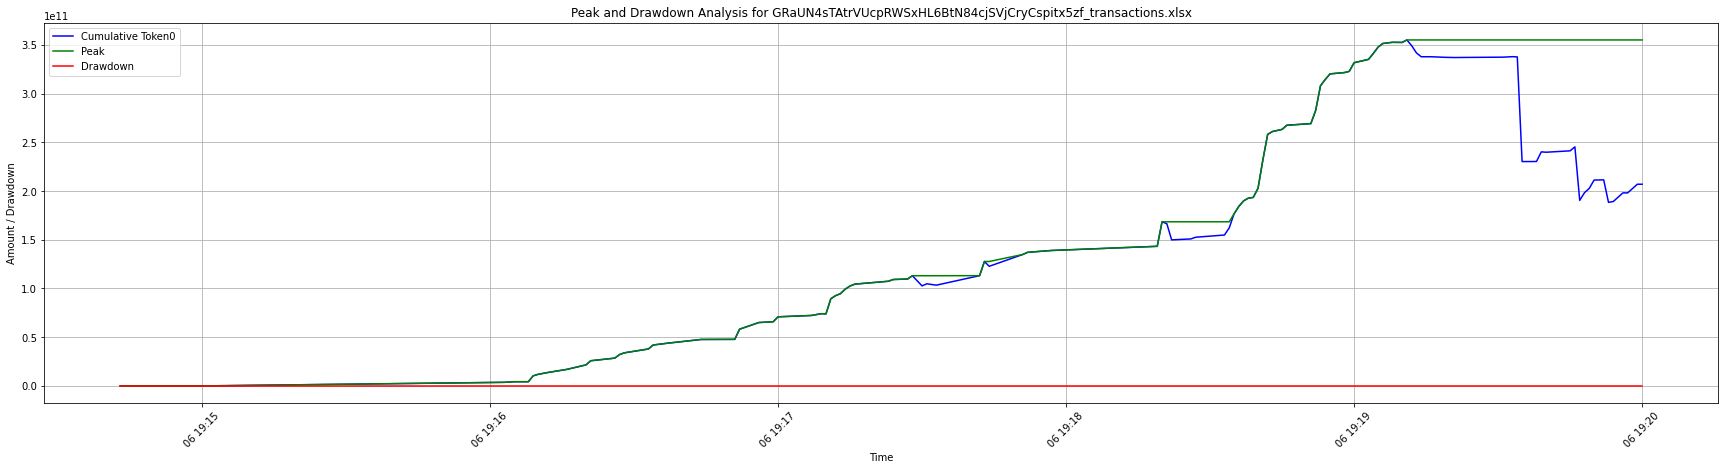

In [5]:
# 读取数据
file = files[0]  # 假设分析第一个文件
df = read(file)

# 处理交易数据
merged_data, filtered_data = process_transaction_data(df)

# 分析最高点和最大回撤
peak_and_drawdown_data = analyze_peak_and_drawdown(merged_data)

# 绘图展示结果
plot_peak_and_drawdown(peak_and_drawdown_data, f'Peak and Drawdown Analysis for {file}')


In [9]:
peak_and_drawdown_data

NameError: name 'peak_and_drawdown_data' is not defined

In [7]:
filtered_data

,From,Token0,Token1,Delta0,Delta1,time,type,pool_price
0,HFEUypA8Sb9EUpvVNqJZ298Xz1yfC2b42SfH31vRa6dH,100000000000,1000000000000000,500000,-4987475124,2024-06-06 19:14:43,buy,0.000100
1,7XJCYHkV5GRp2TYfsauntFVpRkwzojJZLX5ZTqnroCQt,100000500000,999995012524876,500000,-4987425313,2024-06-06 19:14:44,buy,0.000100
2,4ZMVyCZ4c8BXmD7PV1W5ZJsG12EQD5X8Fpsmq5byb6DM,100001000000,999990025099563,1000000,-9974701255,2024-06-06 19:14:45,buy,0.000100
3,8jkHHVbdthtZLyBCYfvEWmKonjjEuiHjRwFZ2oBv9qY1,100002000000,999980050398308,200000,-1994916322,2024-06-06 19:14:46,buy,0.000100
4,8oYMNDMWy9BH19VZL1m5vqhdxMBSqfr32xRKhtwkQo7H,100002200000,999978055481986,100000,-997455171,2024-06-06 19:14:47,buy,0.000100
...,...,...,...,...,...,...,...,...
338,GSF2Q9VnVPS1JRfBtNqxvkmQir4qeLwt6CdpseWE76fx,277192825041,363623357389394,3715345866,-4797488188619,2024-06-06 19:19:59,buy,0.000762
340,DqWmWY58pF23puvEACuEtPMcgkLPRf3qTWEVu28FRFmr,282363222146,356981395774917,2744815893,-3428251688497,2024-06-06 19:19:59,buy,0.000791
336,8aZnHoFoRvk9JL8wiCWkb6TS1w7YT1dWA6PFAMAsLzAe,276244108415,364866567618904,1325387802,-1737894432527,2024-06-06 19:19:59,buy,0.000757
337,BPW1hN7LBfHP3dvXHrfb9F3ta5mP2DXXiyVZ3e6Rak4V,277569496217,363128673186377,-376671176,494684203017,2024-06-06 19:19:59,sell,0.000764


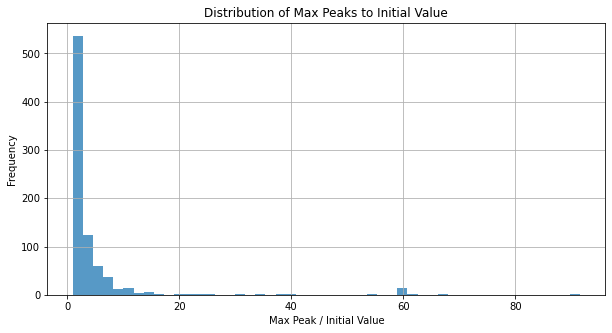

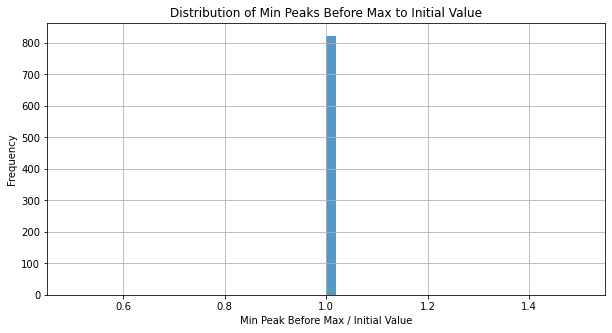

In [4]:
# main_script.py
import os
import pandas as pd
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
from data_processing import read_and_process

def main(folder_path):
    files = [os.path.join(folder_path, file) for file in os.listdir(folder_path)]
    with Pool(cpu_count()) as pool:
        results = pool.map(read_and_process, files)
    results = [result for result in results if result is not None]
    max_peaks, min_peaks_before_max = zip(*results)
    
    return max_peaks, min_peaks_before_max

def plot_distribution(values, title, xlabel):
    plt.figure(figsize=(20, 5))
    plt.hist(values, bins=1000, alpha=0.75)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.title(title)
    plt.grid(True)
    plt.show()

# 读取数据
folder_path = '/Users/ekko/Downloads/coin_data'  # 更改为你的文件夹路径

# 主函数执行
max_peaks, min_peaks_before_max = main(folder_path)

# 绘制分布图
plot_distribution(max_peaks, 'Distribution of Max Peaks to Initial Value', 'Max Peak / Initial Value')
plot_distribution(min_peaks_before_max, 'Distribution of Min Peaks Before Max to Initial Value', 'Min Peak Before Max / Initial Value')


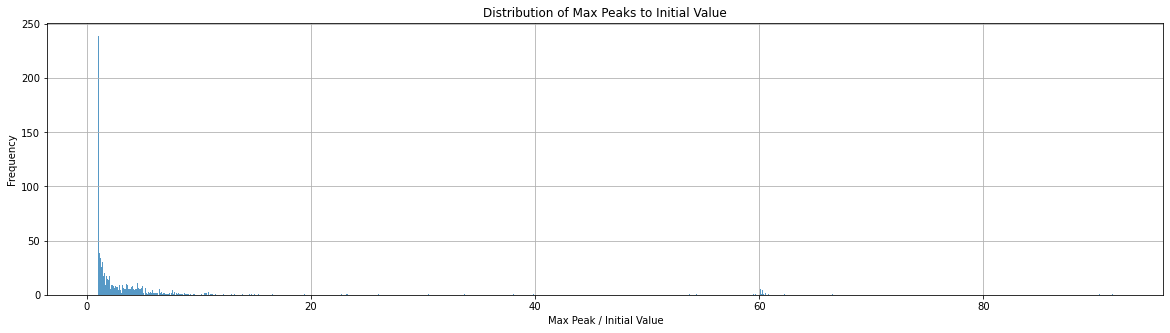

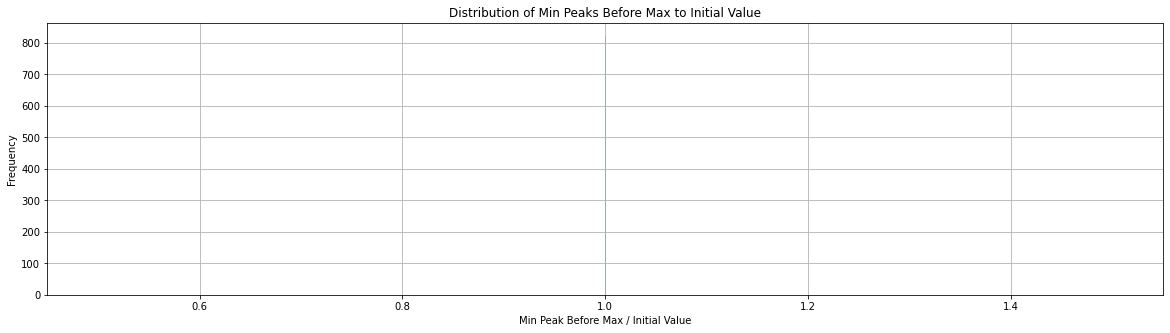

In [6]:
def plot_distribution(values, title, xlabel):
    plt.figure(figsize=(20, 5))
    plt.hist(values, bins=1000, alpha=0.75)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.title(title)
    plt.grid(True)
    plt.show()
# 绘制分布图
plot_distribution(max_peaks, 'Distribution of Max Peaks to Initial Value', 'Max Peak / Initial Value')
plot_distribution(min_peaks_before_max, 'Distribution of Min Peaks Before Max to Initial Value', 'Min Peak Before Max / Initial Value')

In [17]:
import bisect

sort_list = [x for x in max_peaks]
sort_list.sort()
tt = []
for x in range(1, 100):
    tt.append(bisect.bisect_left(sort_list, 1 + x / 100) / len(sort_list))

In [22]:
zz = []
for i in range(len(tt)):
    zz.append((1 + i / 100) * (1-tt[i]))
zz

[0.8625304136253041,
 0.8416666666666667,
 0.8264233576642336,
 0.8157299270072993,
 0.7793673965936739,
 0.7728102189781023,
 0.7724330900243309,
 0.7693065693430657,
 0.765985401459854,
 0.7611435523114355,
 0.7627737226277372,
 0.7643065693430657,
 0.7643795620437956,
 0.764330900243309,
 0.7683211678832117,
 0.7694647201946471,
 0.7733333333333333,
 0.7743065693430657,
 0.7694403892944038,
 0.7730656934306569,
 0.7737226277372262,
 0.7757542579075426,
 0.7762287104622871,
 0.7781021897810219,
 0.7799026763990267,
 0.7770681265206814,
 0.7817518248175183,
 0.7786861313868613,
 0.778588807785888,
 0.7831021897810219,
 0.7844282238442821,
 0.7840875912408759,
 0.7868613138686132,
 0.7895863746958637,
 0.7922627737226279,
 0.7948905109489051,
 0.7974695863746959,
 0.7966666666666669,
 0.7924087591240875,
 0.7947688564476888,
 0.7970802919708029,
 0.7959124087591241,
 0.7981021897810219,
 0.7985036496350364,
 0.7970802919708028,
 0.7990875912408759,
 0.7957177615571775,
 0.7993795620437

In [24]:
tt

[0.13746958637469586,
 0.16666666666666666,
 0.1897810218978102,
 0.20802919708029197,
 0.25060827250608275,
 0.2639902676399027,
 0.2712895377128954,
 0.28102189781021897,
 0.29075425790754256,
 0.30170316301703165,
 0.30656934306569344,
 0.31143552311435524,
 0.3175182481751825,
 0.3236009732360097,
 0.3260340632603406,
 0.3309002433090024,
 0.3333333333333333,
 0.3381995133819951,
 0.34793187347931875,
 0.35036496350364965,
 0.35523114355231145,
 0.3588807785888078,
 0.3637469586374696,
 0.36739659367396593,
 0.3710462287104623,
 0.37834549878345497,
 0.3795620437956204,
 0.38686131386861317,
 0.39172749391727496,
 0.3929440389294404,
 0.39659367396593675,
 0.40145985401459855,
 0.40389294403892945,
 0.40632603406326034,
 0.40875912408759124,
 0.41119221411192214,
 0.41362530413625304,
 0.41849148418491483,
 0.4257907542579075,
 0.4282238442822384,
 0.4306569343065693,
 0.43552311435523117,
 0.43795620437956206,
 0.4416058394160584,
 0.4464720194647202,
 0.4489051094890511,
 0.45498

In [2]:
folder_path = '/Users/ekko/Downloads/coin_data'  # 更改为你的文件夹路径
files = os.listdir(folder_path)

['GRaUN4sTAtrVUcpRWSxHL6BtN84cjSVjCryCspitx5zf_transactions.xlsx',
 'WRm6pkSmiai28635u4eqyrPeB5vyNPQZo8qauKSgDsA_transactions.xlsx',
 'EtJnmzfk56j59FaSqL591LjC2jC4qn5eFibrkpx1nYcy_transactions.xlsx',
 'AVBRvpaxZtfMoR4wXBM5SmcYDbfJ3Ck7zqtu9RZ2o4s3_transactions.xlsx',
 '6y6AyotCySTm1Lx1GkTVGDq6VtnNG811zUwMdboRomaV_transactions.xlsx',
 'Hw8imbewnBRVFYr2skazDr4qe7r87JbJyemZ6U3ZptE9_transactions.xlsx',
 '9h3djVRnXVczmgFZwNMLE7FFFpnEY1Ywo82snCZ3o7xG_transactions.xlsx',
 'Am5TEuKHeqvdRszFbqDA9d1fJnKQGo3nqhzGzPEGV6BP_transactions.xlsx',
 '7yGa2hMUwggJkimSZHkfE5grg8F7iDNRkN1BH2P2FUXD_transactions.xlsx',
 '58YzzWZ1UYsgu4rBG82ArUmV9762NfruwYZeV1sKBoWy_transactions.xlsx',
 'CFpZizdTiijENM8d4yYcmyyKmNA5o6eQAE31CzvNoHBk_transactions.xlsx',
 'C15pzPzZGT5MYa87wP9BXTbt6JAz48fHvM36fY9GPthf_transactions.xlsx',
 '68sKkGeyogQDKg2dCcYT9e41m5bFE5P9U4kkFoaruT1A_transactions.xlsx',
 'BadmNNsdZZ8sdL9eKV79doky9Lgg5Mb6ndGYVzgoUZ5x_transactions.xlsx',
 'C7rYkyBU5UQYD9RVU9cHsKxUK517xR7J2fbWufsBvGB4_transactions.xls

In [26]:
# main_script.py
import os
import pandas as pd
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
from data_processing import read_and_process

def main(folder_path):
    files = [os.path.join(folder_path, file) for file in os.listdir(folder_path)]
    with Pool(cpu_count()) as pool:
        results = pool.map(read_and_process, files)
    
    # 过滤掉处理失败的结果
    all_features = []
    all_targets = []
    for features, targets in results:
        if features is not None and targets is not None:
            all_features.extend(features)
            all_targets.extend(targets)

    return all_features, all_targets

# 绘制时间分布图
def plot_crash_time_distribution(crash_times_df):
    plt.figure(figsize=(12, 6))
    crash_times_df['hour'].value_counts().sort_index().plot(kind='bar')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Crash Events')
    plt.title('Distribution of Crash Events by Hour of Day')
    plt.grid(True)
    plt.show()

# 读取数据
folder_path = '../coin_data'  # 更改为你的文件夹路径

# 主函数执行
all_features, all_targets = main(folder_path)

# 转换为DataFrame
features_df = pd.DataFrame(all_features)
targets_df = pd.DataFrame(all_targets)

# 合并特征和目标变量
data_df = pd.concat([features_df, targets_df], axis=1)

# 保存数据
data_df.to_csv('features_targets.csv', index=False)

print("Data collection complete.")
